In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from utils import preprocessing, transforms
from utils.constants import PLOTCOLORS
import matplotlib.pyplot as plt

RANDOM_STATE = 21

cwd = Path.cwd()
husky_data = cwd / "norlab-data"
vulpi_data = cwd / "data"
figs_path = cwd / "analysis" / "figs"
figs_path.mkdir(parents=True, exist_ok=True)

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

In [3]:
husky_summ = summary.copy()
vulpi_summ = summary.copy()

husky_dfs = preprocessing.get_recordings(husky_data, husky_summ)
vulpi_dfs = preprocessing.get_recordings(vulpi_data, vulpi_summ)

husky_pro = husky_dfs["pro"].copy()
vulpi_pro = vulpi_dfs["pro"].copy()

In [4]:
husky_pro["vx"], husky_pro["wz"] = transforms.unicycle_model(husky_pro)
vulpi_pro["vx"], vulpi_pro["wz"] = transforms.unicycle_model(vulpi_pro)

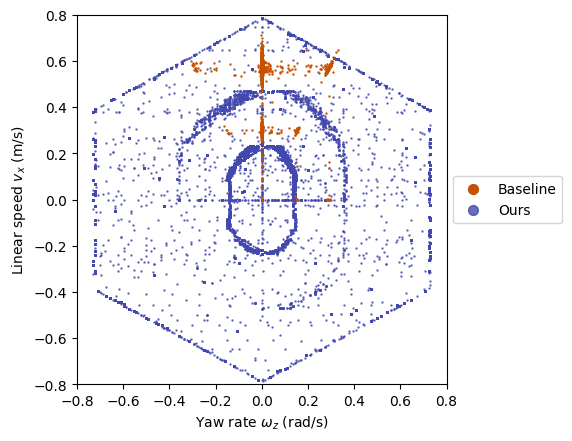

In [5]:
fig, ax = plt.subplots()
# for terr in husky_pro.terrain.unique():
#     terrdat = husky_pro[husky_pro.terrain == terr]
#     terrn = terr.lower().replace("_", " ")
#     ax.scatter(
#         terrdat.wz,
#         terrdat.vx,
#         c="g",
#         s=0.4,
#         # label=terrn,
#         # c=PLOTCOLORS[terrn],
#         # alpha=1,
#     )
# for terr in vulpi_pro.terrain.unique():
#     terrdat = vulpi_pro[vulpi_pro.terrain == terr]
#     terrn = terr.lower().replace("_", " ")
#     ax.scatter(
#         terrdat.wz,
#         terrdat.vx,
#         c="b",
#         s=0.4,
#         # label=terrn,
#         # c=PLOTCOLORS[terrn],
#         # alpha=1,
#     )
ax.scatter(
    vulpi_pro.wz,
    vulpi_pro.vx,
    c=PLOTCOLORS["sandy loam"],
    s=0.5,
    alpha=1,
    label="Baseline",
    zorder=5
)
ax.scatter(
    husky_pro.wz,
    husky_pro.vx,
    c=PLOTCOLORS["concrete"],
    s=0.5,
    alpha=0.8,
    label="Ours",
    zorder=-1
)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=10)

ax.set_xlabel("Yaw rate $\omega_z$ (rad/s)")
ax.set_ylabel("Linear speed $v_x$ (m/s)")

ax.set_aspect("equal")
ax.set_xlim((-0.8, 0.8))
ax.set_ylim((-0.8, 0.8))
# ax.set_xlim((-0.05, 0.8))
# ax.set_ylim((-0.05, 0.8))

ax.get_legend_handles_labels()
ax.get_legend()

fig.savefig(figs_path / "speeds.pdf", bbox_inches="tight")